In [1]:
import numpy as np
from functools import partial
import os

import llmize
from llmize import OPRO
import llmize.utils

def initialize_tsp(num_cities, seed=42):
    """
    Initializes the TSP with random city coordinates.
    :param num_cities: Number of cities
    :param seed: Random seed for reproducibility
    :return: Distance matrix
    """
    np.random.seed(seed)
    cities = np.random.rand(num_cities, 2) * 100  # Random cities in 100x100 space
    
    # Compute distance matrix
    dist_matrix = np.sqrt(((cities[:, np.newaxis] - cities[np.newaxis, :]) ** 2).sum(axis=2))
    return dist_matrix

def objective_function(route, dist_matrix):
    """
    Computes the total travel distance for a given route.
    :param route: A permutation of city indices representing the tour
    :param dist_matrix: Precomputed distance matrix
    :return: Total distance of the route
    """
    total_distance = sum(dist_matrix[route[i], route[i+1]] for i in range(len(route) - 1))
    total_distance += dist_matrix[route[-1], route[0]]  # Return to starting city
    return total_distance


/home/rizki/llmize/llmize/methods/opro.py:65: SyntaxWarning: invalid escape sequence '\s'
  """
/home/rizki/anaconda3/envs/genai_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_cities = 10
dist_matrix = initialize_tsp(num_cities)
# generate 5 random routes and total distances
routes = [np.random.permutation(num_cities) for _ in range(5)]
total_distances = [objective_function(route, dist_matrix) for route in routes]

print(routes)
print(total_distances)


[array([1, 5, 4, 8, 0, 7, 6, 3, 2, 9]), array([8, 2, 5, 7, 3, 1, 9, 0, 4, 6]), array([0, 5, 2, 6, 3, 7, 4, 1, 8, 9]), array([4, 8, 1, 3, 0, 5, 2, 9, 7, 6]), array([2, 0, 4, 9, 8, 6, 7, 5, 1, 3])]
[np.float64(612.9578815596241), np.float64(602.863725821969), np.float64(577.0165345439927), np.float64(479.31678334900784), np.float64(618.4446098740465)]


In [3]:
with open("tsp_problem.txt", "r") as f:
    problem_text = f.read()

# Initialize the OPRO optimizer
opro = OPRO(problem_text=problem_text, obj_func=partial(objective_function, dist_matrix=dist_matrix),
            llm_model="gemini-2.0-flash", api_key=os.getenv("GEMINI_API_KEY"))

prompt = opro.get_sample_prompt(init_samples=routes, init_scores=total_distances, optimization_type="minimize")
response = opro.get_sample_response(prompt)

llmize.utils.pretty_print(prompt=prompt, response=response)



Prompt: I want you to help me solve the Traveling Salesman Problem (TSP) for 10 randomly placed cities within a 
100x100 coordinate space. The objective is to find the shortest possible route that visits each city exactly once 
and returns to the starting point.

In the TSP, the goal is to minimize the total distance traveled by visiting each city only once and returning to 
the starting city, creating a closed loop. The cities are represented as points on a 2D grid, where each city has 
an x and y coordinate within the 100x100 space.

For each pair of cities, the distance between them is calculated using the Euclidean distance formula. The distance
between two cities is the square root of the sum of the squared differences between their x and y coordinates.
Below are some examples of solutions and their scores:
<sol> 1,5,4,8,0,7,6,3,2,9 <\sol>
score: 612.96

<sol> 8,2,5,7,3,1,9,0,4,6 <\sol>
score: 602.86

<sol> 0,5,2,6,3,7,4,1,8,9 <\sol>
score: 577.02

<sol> 4,8,1,3,0,5,2,9,7,6 <\sol>
score: 479.32

<sol> 2,0,4,9,8,6,7,5,1,3 <\sol>
score: 618.44

Generate exactly 5 new solutions that:
- Are distinct from all previous solutions.
- Have lower scores than the lowest provided.
- Respect the relationships based on logical reasoning.

Each solution should start with <sol> and end with <\sol> with a comma between parameters. 
Make sure the length of solutions match examples given. Don't guess for the scores as they will be calculated by an
objective function.

Response: Okay, I will generate 5 new solutions for the Traveling Salesman Problem with 10 cities, attempting to 
find routes shorter than the best score provided (479.32).  Since I don't have an actual distance calculator, these
are based on heuristics -- trying to cluster nearby cities and avoid large jumps.

```
<sol> 4,1,8,3,0,5,2,9,7,6 </sol>[ /bold cyan]
<sol> 4,8,1,3,5,0,2,9,7,6 </sol>[ /bold cyan]
<sol> 4,8,1,3,2,0,5,9,7,6 </sol>[ /bold cyan]
<sol> 6,7,9,2,5,0,3,1,8,4 </sol>[ /bold cyan]
<sol> 6,7,9,5,2,0,3,1,8,4 </sol>[ /bold cyan]
```

In [4]:
from llmize.callbacks import EarlyStopping, AdaptTempOnPlateau

# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='best_score', min_delta=1.0, patience=3, verbose=1)

# Define the temperature adaptation callback
adapt_temp_callback = AdaptTempOnPlateau(monitor='best_score', init_temperature=0.9, min_delta=1.0, patience=2, factor=1.2, verbose=1)

print(adapt_temp_callback)

In [5]:
callbacks=[earlystop_callback, adapt_temp_callback]
print(callbacks)

[<llmize.callbacks.early_stopping.EarlyStopping object at 0x7ff6d1d5d010>, <llmize.callbacks.adapt_temp_on_plateau.AdaptTempOnPlateau object at 0x7ff6d1d5cec0>]


In [ ]:
results = opro.minimize(init_samples=routes, init_scores=total_distances, callbacks=callbacks)

[array([1, 5, 4, 8, 0, 7, 6, 3, 2, 9]), array([8, 2, 5, 7, 3, 1, 9, 0, 4, 6]), array([0, 5, 2, 6, 3, 7, 4, 1, 8, 9]), array([4, 8, 1, 3, 0, 5, 2, 9, 7, 6]), array([2, 0, 4, 9, 8, 6, 7, 5, 1, 3])] [np.float64(612.9578815596241), np.float64(602.863725821969), np.float64(577.0165345439927), np.float64(479.31678334900784), np.float64(618.4446098740465)] 50 5 None


/home/rizki/llmize/llmize/methods/opro.py:65: SyntaxWarning: invalid escape sequence '\s'
  """


NameError: name 'exit' is not defined

In [ ]:

print(results['best_solution'])
print(results['best_score'])

[6, 9, 7, 2, 5, 0, 8, 4, 1]
324.81778823572586


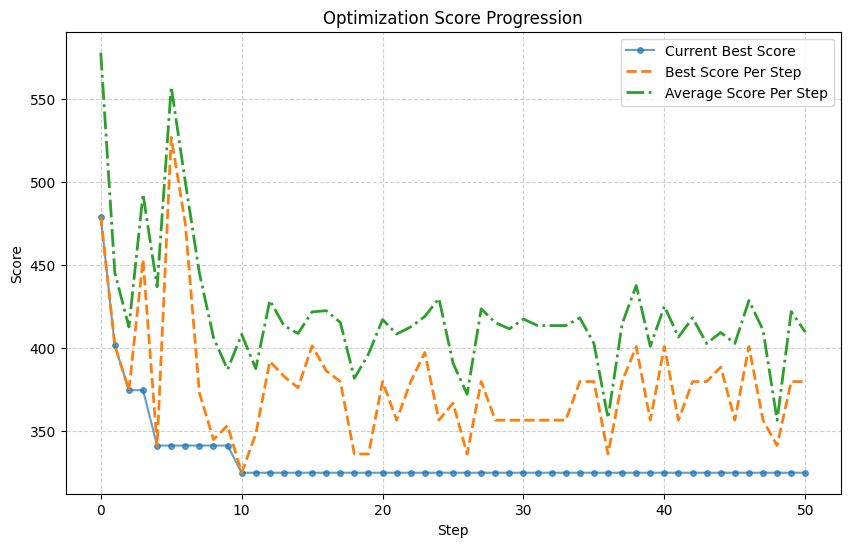

In [ ]:
from llmize.utils.plotting import plot_scores

plot_scores(results)